Gad2	GCaMP7s
171	VISal



source//allen/programs/mindscope/production/learning/prod0/specimen_1179706244/ophys_session_1189276987/ophys_experiment_1189514812
/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data

raw: /allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1189276987/raw
processed: /allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1189276987/processed/1189514802

processed
7e6369ef-ed60-4f11-b7f8-f363eb628633
raw
ff7bda54-924e-444c-93fd-0b01766f2080

In [12]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt

from ophys.ophys_plane_dataset import OphysPlaneDataset

In [14]:
from ophys.grab_ophys import GrabOphysOutputs as GOO
goo = GOO("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
goo

In [16]:
goo2 = GOO(oeid=1098444819, data_path="/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data")
goo2

In [54]:
def dff_robust_noise(dff_trace):
    """Robust estimate of std of noise in df/f

    Arguments:
        dff_trace {[type]} -- [description]

    Returns:
        [type] -- [description]
    """

    sigma_MAD_conversion_factor = 1.4826

    dff_trace = np.asarray(dff_trace)
    # first pass removing big pos peaks
    dff_trace = dff_trace[dff_trace < 1.5 * np.abs(dff_trace.min())]
    MAD = np.median(np.abs(dff_trace - np.median(dff_trace)))  # MAD = median absolute deviation
    robust_standard_deviation = sigma_MAD_conversion_factor * MAD

    # second pass removing remaining pos and neg peaks
    dff_trace = dff_trace[np.abs(dff_trace - np.median(dff_trace)) < 2.5 * robust_standard_deviation]
    MAD = np.median(np.abs(dff_trace - np.median(dff_trace)))
    robust_standard_deviation = sigma_MAD_conversion_factor * MAD
    return robust_standard_deviation

def dff_robust_signal(dff_trace, robust_standard_deviation):
    """ median deviation

    Arguments:
        dff_trace {[type]} -- [description]
        robust_standard_deviation {[type]} -- [description]

    Returns:
        [type] -- [description]
    """
    dff_trace = np.asarray(dff_trace)
    median_deviation = np.median(dff_trace[(dff_trace - np.median(dff_trace)) > robust_standard_deviation])
    return median_deviation

def dff_robust_snr(robust_signal, robust_noise):
    mean_snr = np.mean(robust_signal / robust_noise)
    return

def compute_robust_snr_on_dataframe(dataframe):
    """takes a dataframe with a "dff" column that has the dff trace array
        for a cell_specimen_id and for noise uses Robust estimate of std for signal
        uses median deviation, and for robust snr the robust signal / robust noise

    Arguments:
        dataframe {[type]} -- [description]

    Returns:
        dataframe -- input dataframe but with the following columns added:
                        "robust_noise"
                        "robust_signal"
                        "robust_snr"
    """
    if 'dff' in dataframe.columns:
        column = 'dff'
    elif 'filtered_events' in dataframe.columns:
        column = 'filtered_events'
    dataframe['robust_noise'] = dataframe.apply(lambda x: dff_robust_noise(x[column]), axis=1) 
    dataframe["robust_signal"] = dataframe.apply(lambda x: dff_robust_signal(x[column], x["robust_noise"]), axis=1 )
    dataframe['robust_snr']  = dataframe['robust_signal'] / dataframe['robust_noise']
    return dataframe

In [ ]:
# get top 1 percentile of dff
def get_top_percentile_of_dff(dataframe, percentile=99):
    if 'dff' in dataframe.columns:
        column = 'dff'
    elif 'filtered_events' in dataframe.columns:
        column = 'filtered_events'
    percentile_value = np.percentile(dataframe[column], percentile)
    #return dataframe[dataframe[column] > percentile_value]
    return percentile_value

In [62]:
processed_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/1299958728" # give experiment
raw_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/raw"

#dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
dataset = OphysPlaneDataset(processed_path, raw_path)

dff_traces = dataset.dff_traces
n_og_dff_traces = len(dff_traces)






# remove rows in dff_traces where skewness is nan
dff_traces = dff_traces[dff_traces.skewness.notna()]
n_dff_traces = len(dff_traces)
print(f"Removed {n_og_dff_traces - n_dff_traces} rows from dff_traces where skewness was nan")
print(f"N dff_traces: {n_dff_traces}")

dff_traces = compute_robust_snr_on_dataframe(dff_traces)

noise = dff_traces.noise.values
skewness = dff_traces.skewness.values
robust_snr = dff_traces.robust_snr.values

dff_traces.head()

Currently sync file stored in raw data assest, will load since raw_folder_path is provided (02/01/2024)
Removed 8 rows from dff_traces where skewness was nan
N dff_traces: 73


<ipython-input-54-80e4af95dcae>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['robust_noise'] = dataframe.apply(lambda x: dff_robust_noise(x[column]), axis=1)
<ipython-input-54-80e4af95dcae>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["robust_signal"] = dataframe.apply(lambda x: dff_robust_signal(x[column], x["robust_noise"]), axis=1 )
<ipython-input-54-80e4af95dcae>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,dff,baseline,noise,skewness,robust_noise,robust_signal,robust_snr
cell_specimen_id,,,,,,,
10,"[0.2590196997004517, 0.18960400179453218, 0.24...","[2418.167761571288, 2418.167761571288, 2418.16...",162.071484,0.322384,0.132313,0.232595,1.757912
11,"[0.14345842641369522, 0.26765181864374543, 0.1...","[1332.4583180076627, 1332.4583180076627, 1332....",112.761395,0.755166,0.138091,0.282970,2.049154
12,"[0.17683583095468602, 0.10960230885661967, 0.1...","[1722.1217291917526, 1722.1217291917526, 1722....",104.438841,0.597191,0.117373,0.218395,1.860687
13,"[0.20830519429840344, 0.09599613239045518, 0.1...","[1562.9695231012818, 1562.588110577985, 1562.5...",85.762526,0.523705,0.112552,0.209563,1.861929
14,"[0.2996219305878485, 0.24843730078292894, 0.40...","[1609.4206893190785, 1609.4206893190785, 1610....",112.513291,0.689286,0.104231,0.181521,1.741520


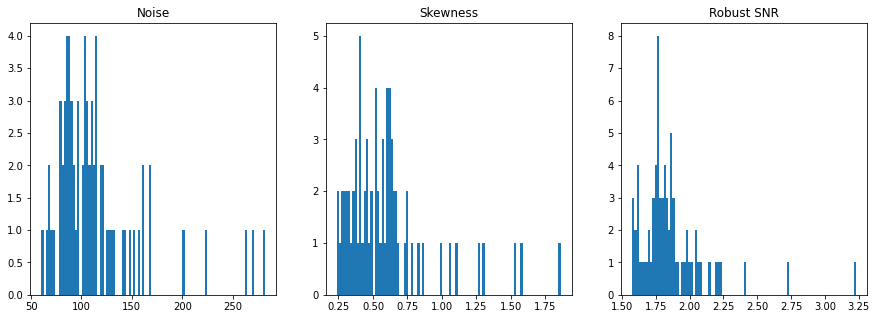

In [61]:
#plt hist of noise, skewness, robust_snr
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(noise, bins=100)
ax[0].set_title("Noise")
ax[1].hist(skewness, bins=100)
ax[1].set_title("Skewness")
ax[2].hist(robust_snr, bins=100)
ax[2].set_title("Robust SNR")
plt.show()


In [63]:
# save csv with only columns, noise, snr, skewness
save_df = dff_traces[["noise", "robust_snr", "skewness"]]
save_df.to_csv("dff_metrics.csv")

,noise,robust_snr,skewness
cell_specimen_id,,,
10,162.071484,1.757912,0.322384
11,112.761395,2.049154,0.755166
12,104.438841,1.860687,0.597191
13,85.762526,1.861929,0.523705
14,112.513291,1.741520,0.689286
...,...,...,...
75,161.28411,2.224970,0.74721
78,262.590612,1.613807,0.351564
79,223.650668,1.575522,0.342916


In [40]:
# load dff, ['baseline', 'data', 'noise', 'roi_names', 'skewness']
fp = dataset.file_paths["dff_h5"]

import h5py
with h5py.File(fp, 'r') as f:
    print(f["skewness"][:].shape)

(81,)


<xarray.DataArray 'RMSE' ()>
array(0.00506034)
Coordinates:
    cell_roi_id  int64 2

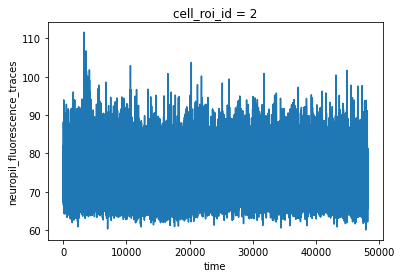

In [98]:
import xarray as xr
dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
x = dataset.neuropil_traces_xr

# get cell_roi_id 0 from x 
cell_roi_id = 1
x.sel(cell_roi_id=cell_roi_id).neuropil_fluorescence_traces.plot.line()
x.sel(cell_roi_id=cell_roi_id).RMSE


In [48]:
dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
dataset.cell_specimen_table.head()

,x,y,width,height,mask_matrix,valid_roi,mask_image_plane,exclusion_labels,cell_roi_id,max_correction_up,max_correction_down,max_correction_left,max_correction_right
cell_specimen_id,,,,,,,,,,,,,
0,44,0,6,6,"[[False, True, True, True, False, False], [Tru...",False,0,[small_size],0,0,0,0,0
1,79,12,14,17,"[[False, False, False, False, False, False, Tr...",True,0,[],1,0,0,0,0
2,206,49,20,11,"[[False, False, False, False, False, False, Fa...",True,0,[],2,0,0,0,0
3,344,58,12,11,"[[False, True, True, True, True, False, False,...",True,0,[],3,0,0,0,0
4,53,66,15,13,"[[False, False, False, False, False, False, Fa...",True,0,[],4,0,0,0,0
